# Assignment 5 - Testing

### Step 1 - Data Import

Shape of input data: (29492, 14, 14)


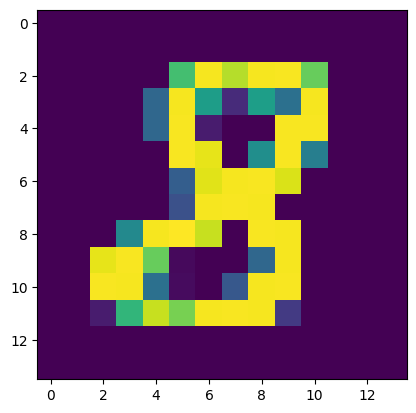

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

cwd = os.getcwd()
ass_dir = cwd.rsplit('\\', maxsplit=1)[0]

raw_data = np.loadtxt(os.path.join(ass_dir, r'data\even_mnist.csv'), dtype=str)

# separate label from images
input = raw_data[:, :-1]
label = raw_data[:, -1:]

# reshape the flattened images into 2D
input = input.reshape((len(label), 14, 14)).astype(int)
print("Shape of input data:", input.shape)

# take a look at a digit
plt.style.use('default')
plt.imshow(input[2001])
plt.show()

### Step 2 - Setup Encoder Portion

In [2]:
import torch
import torch.nn as nn

# define latent size for tuning purposes
latent_size = 20
kernal_size = 3

class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.con_layer1 = nn.Conv2d(1, 7, 3, padding=1, stride=2) # we only have one input channel (i.e. non-RGB)
        self.batch = nn.BatchNorm2d(7)
        self.con_layer2 = nn.Conv2d(7, 14, 3, padding=0, stride=1)
        self.lin1 = nn.Linear(3*14, 49) # linear layer after convolutions
        self.lin_mu = nn.Linear(49, latent_size) # layer for mu
        self.lin_sigma = nn.Linear(49, latent_size) # layer for sigma

        # initialize KL for now
        self.kl = 0

    def forward(self, x):
        # first convolution layer
        x = self.con_layer1(x)
        x = nn.ReLU(x)

        # batch layer
        x = self.batch(x)
        x = nn.ReLU(x)

        # second convolution layer
        x = self.con_layer2(x)
        x = nn.ReLU(x)

        # flatten and send to lienar layers
        x = torch.flatten(x, start_dim=1)
        x = self.lin1(x)
        x = nn.ReLU(x)

        # separate layers for mu and sigma
        mu = self.lin_mu(x)
        log_sigma = self.lin_sigma(x)
        sigma = torch.exp(log_sigma)

        # combine sigma and mu to produce z
        z = sigma*torch.distributions.Normal(0, 1).sample(mu.shape) + mu\
        
        # KL metric
        self.kl = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - sigma.pow(2))

        return z